# Load

## Libs

In [2]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


## data

In [3]:
# obj <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts.rds')

In [4]:
# dname <- '/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/'
# fields_load <- c('gsea', 'masc', 'masc_meta', 'effects_marginal', 'meta_data')
# obj <- map(fields_load, function(name) {
#     readRDS(file.path(dname, paste0(name, '.rds')))
# })
# names(obj) <- fields_load


In [5]:
cluster_names_df <- unique(dplyr::select(readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/meta_data.rds'), Cluster, Cluster_name))

In [6]:
# ## Get fibroblast clusters signatures 
# ## Pan-tissue
# gs_marginal <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_marginal.rds') %>% 
#     subset(pvalue < .05 & beta > log(2)) %>% 
#     split(.$Cluster) %>% 
#     map('feature')

# names(gs_marginal) <- paste0('C', names(gs_marginal))

# ## Tissue-specific
# gs_fls <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% 
#     subset(Tissue == 'Synovium') %>% 
#     subset(pvalue < .05 & beta > log(2)) %>% 
#     split(.$Cluster) %>% 
#     map('feature')
# names(gs_fls) <- paste0('C', names(gs_fls))


# gs_lung <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% 
#     subset(Tissue == 'Lung') %>% 
#     subset(pvalue < .05 & beta > log(2)) %>% 
#     split(.$Cluster) %>% 
#     map('feature')
# names(gs_lung) <- paste0('C', names(gs_lung))


In [7]:
ddres_costim <- readRDS('/data/srlab2/ik936/Roche/data/cache/stim_revisions_ddres_v1.rds')

In [8]:
## Get pseudobulk expression to plot in heatmap 
obj_costim <- readRDS('/data/srlab2/ik936/Roche/data/cache/revision1_stim_object.rds')
pb_costim <- presto::collapse_counts(obj_costim$exprs_raw, obj_costim$meta_data, c('DonorID', 'Condition', 'Tissue'))

## Z-score within tissue 
pb_costim$exprs_scaled <- pb_costim$meta_data %>% split(.$Tissue) %>% map(function(.SD) {
    scaleData(pb_costim$exprs_norm[, rownames(.SD)], margin = 1, thresh = 5)
}) %>% 
    purrr::reduce(Matrix::cbind2)
pb_costim$exprs_scaled <- pb_costim$exprs_scaled[, colnames(pb_costim$exprs_norm)]
pb_costim$exprs_scaled[which(is.na(pb_costim$exprs_scaled))] <- 0

CAREFUL: get_norm makes very strong assumptions about data



In [9]:
obj_costim_fls <- readRDS('/data/srlab2/ik936/Roche/data/cache/revision1_stim_object_synovium.rds')
obj_costim_lung <- readRDS('/data/srlab2/ik936/Roche/data/cache/revision1_stim_object_lung.rds')

In [10]:
obj_costim_fls$meta_data$Condition <- factor(obj_costim_fls$meta_data$Condition, c('Control', 'Tcells', 'ECs'))
obj_costim_lung$meta_data$Condition <- factor(obj_costim_lung$meta_data$Condition, c('Control', 'Tcells', 'ECs'))

In [11]:
# obj$gsea %>% 
#     inner_join(pathway_df, by = 'pathway') %>% 
#     tidyr::unnest(leadingEdge) %>% 
#     inner_join(
#         obj$effects_marginal %>% 
#             subset(pvalue < 0.05 & beta > 0 & Cluster %in% c('4', '11')),
#         by = c('leadingEdge' = 'feature', 'Cluster')
#     ) %>% 
#     subset(grepl('develop', pathway, ignore.case = TRUE) & Cluster == '4') %>% 
#     split(paste(.$name, .$Cluster)) %>% 
# #     subset(grepl('^COL\\d', leadingEdge)) %>% 
# #     map(arrange, -zscore) %>% 
#     identity()


# Costim UMAPs

In [12]:
colors_use <- c(
    colorRampPalette(c('white', palette_global[['lung']]))(4)[2:4],
    colorRampPalette(c('white', palette_global[['synovium']]))(4)[2:4]
)
names(colors_use) <- c('Lung_B', 'Lung_C', 'Lung_A', 'Synovium_C', 'Synovium_B', 'Synovium_A')

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


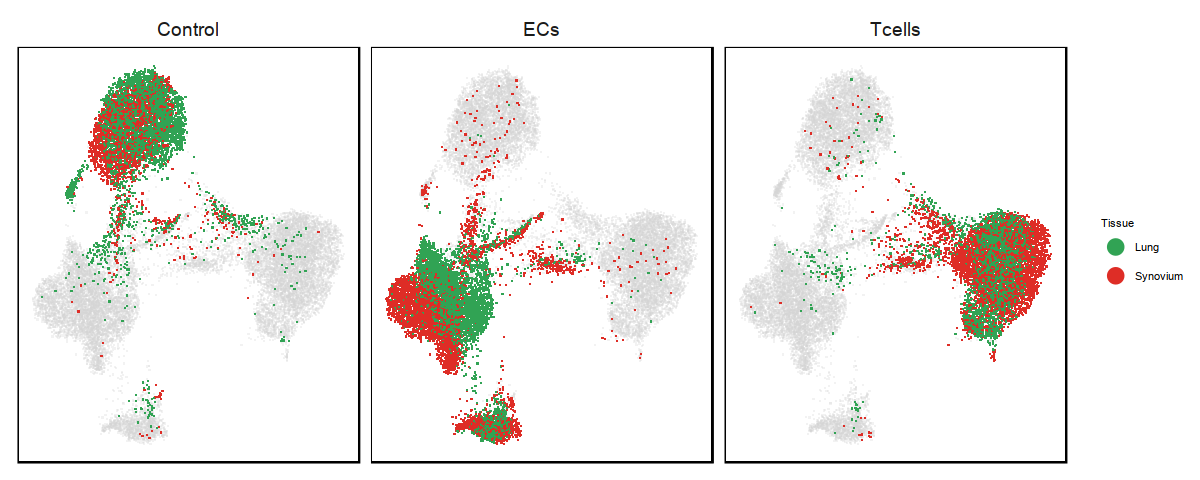

In [13]:
fig.size(4, 10)
p_umap <- do_scatter(
    obj_costim$Uh$embedding,
    obj_costim$meta_data, 
    'Tissue', quo(Condition), 
    do_labels=FALSE, no_guides=FALSE, nrow=1,
    palette_use=palette_global[c('Lung', 'Synovium')]
#     palette_use=colors_use
) + 
    theme(
#         legend.position="bottom",
        legend.text = element_text(size=6),
        legend.title = element_text(size=6),
        plot.title = element_text(size=12),
        axis.ticks = element_blank(), 
        axis.text = element_blank(),
        axis.title = element_blank()
#         axis.title.x = element_blank()
    ) + 
#     labs(color = 'Tissue_CellLine', fill = 'Tissue_CellLine') + 
    NULL
p_umap

# Costim signatures heatmap

In [14]:
# data.table(ddres_costim)[padj < .05 & stat > 0, .SD[order(-log2FoldChange)][1:10], by = .(Tissue, Condition)]
#[, .N, by = .(Tissue, Condition)]
# data.table(ddres_costim)[padj < .05 & stat > 0, .SD[order(-stat)][1:10], by = .(Tissue, Condition)]

# genes_plot_tcells <- data.table(ddres_costim)[padj < .01 & log2FoldChange > 2, .SD[order(-stat)], by = .(Tissue, Condition)][Condition == 'Tcells', unique(feature)]
# genes_plot_ecs <- data.table(ddres_costim)[padj < .01 & log2FoldChange > 2, .SD[order(-stat)], by = .(Tissue, Condition)][Condition == 'ECs', unique(feature)]

genes_plot <- data.table(ddres_costim)[padj < .01 & log2FoldChange > 2, .SD[order(-stat)], by = .(Condition)][, unique(feature)]

# genes_highlight <- data.table(ddres_costim)[padj < .01 & log2FoldChange > 2, .SD[order(-stat)][1:5], by = .(Tissue, Condition)][, unique(feature)] 
# genes_highlight <- ddres_costim %>% 
#     subset(padj < .01 & log2FoldChange > 2) %>% 
#     dplyr::select(Tissue, Condition, feature, log2FoldChange) %>% 
#     tidyr::spread(Tissue, log2FoldChange) %>% 
#     subset(!is.na(lung) & !is.na(fls)) %>% 
#     split(.$Condition) %>% 
#     map(function(.SD) {
#         .SD %>% 
#             arrange(-(fls*lung)) %>% 
#             head(10)
#     }) %>% 
#     bind_rows() %>% 
#     with(unique(feature)) 

genes_highlight <- c('CXCL10', 'CXCL11', 'CCL19', 'IGFBP2', 'ZBTB16', 'CCND2')

# genes_highlight <- union(genes_highlight, c('CXCL10', 'CCL19', 'SPARC'))
row_o <- pb_costim$meta_data %>% arrange(Condition, Tissue) %>% rownames()
mat <- t(pb_costim$exprs_scaled[genes_plot, row_o])
rownames(mat) <- glue('{Tissue} {Condition}', .envir = pb_costim$meta_data[row_o, ])


In [15]:
set.seed(53L) ## Random seed for column order
anno_cols <- data.table(ddres_costim)[
    feature %in% genes_plot
][
    , .(score = mean(log2FoldChange)), by = .(feature, Condition)
][
    , .SD[order(-score)][1], by = feature
][
    , .(feature, Condition)
][, dplyr::sample_frac(.SD, 1L), by = Condition] %>% 
    data.frame() %>% 
    tibble::column_to_rownames('feature') %>% 
    arrange(Condition)

# anno_cols <- anno_cols[colnames(mat), , drop = FALSE]
mat <- mat[, rownames(anno_cols), drop = FALSE]

rownames_use <- rownames(mat)
rownames_use <- gsub(' ', '\n', rownames_use)
rownames_use[setdiff(seq_len(length(rownames_use)), seq(2, by = 3, length.out = length(rownames_use)/3))] <- ''
rownames_use

[1] ""                  "Lung\nControl"     ""                 
 [4] ""                  "Synovium\nControl" ""                 
 [7] ""                  "Lung\nECs"         ""                 
[10] ""                  "Synovium\nECs"     ""                 
[13] ""                  "Lung\nTcells"      ""                 
[16] ""                  "Synovium\nTcells"  ""

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Loading required namespace: jpeg



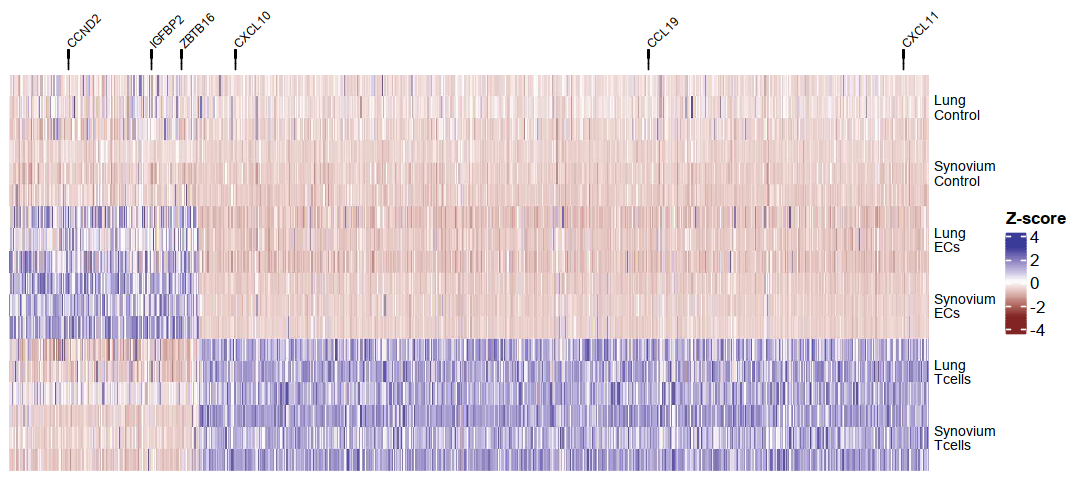

In [16]:
ccl <- colnames(mat) %in% genes_highlight
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 8))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 8))

fig.size(4, 9)
h1 <- Heatmap(
    matrix = mat, 
    name = 'Z-score', 
    show_column_names = FALSE,
    show_column_dend = FALSE,    
    colorRamp2(c(-3, 0, 3), c(muted('red'), 'white', muted('blue'))),    
    column_names_rot = 90, 
    use_raster = TRUE, raster_device = "CairoJPEG",
    cluster_rows = FALSE, 
    cluster_columns = FALSE, 
    show_heatmap_legend = TRUE, 
    row_labels = rownames_use,     
#     heatmap_legend_param = list(
#         legend_direction = "horizontal",
#         title_position = 'lefttop',
#         legend_height = unit(.5, "cm")
#     ),
    top_annotation = columnAnnotation(
#         show_legend = FALSE, 
#         show_annotation_name = FALSE,
        link = anno_mark(
            at = which(ccl), 
            labels = colnames(mat)[ccl], 
            labels_gp = gpar(fontsize = 7), padding = unit(1, "mm"),
            labels_rot = 45
        )
#         Condition = anno_cols$Condition,
#         col = palette_heatmap
    ),
)

# draw(h1, heatmap_legend_side = 'bottom')
draw(h1)

p_stim_heat <- grid.grabExpr(draw(h1))
# p_stim_heat <- grid.grabExpr(draw(h1, heatmap_legend_side = 'bottom'))



# Tissue-vs-tissue 

CAUTION: relies on data structures set up in section above. 


Joining, by = c("feature", "Condition")



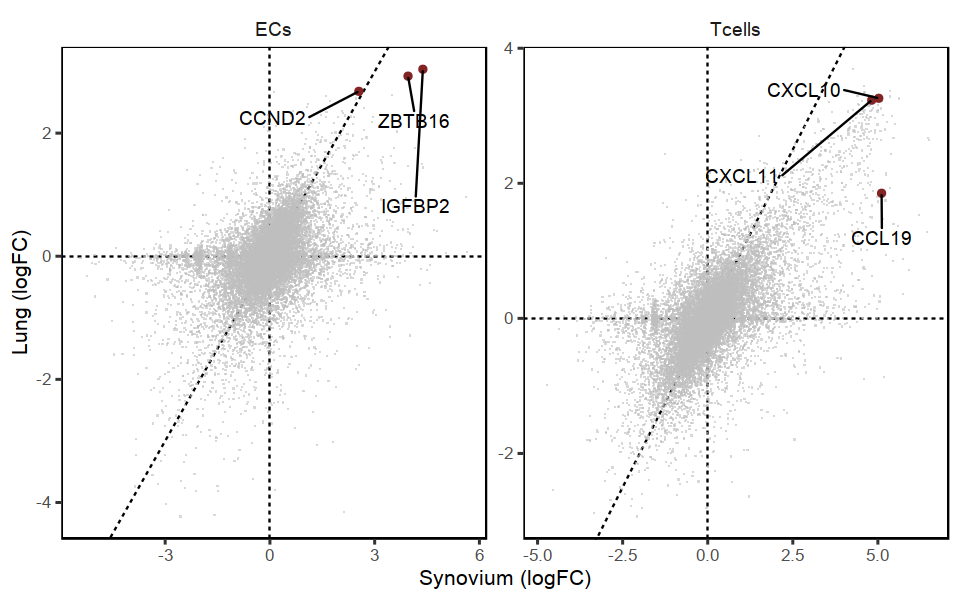

In [17]:
fig.size(5, 8)
set.seed(42L)
plt_df <- ddres_costim %>% 
#     dplyr::select(Tissue, Condition, SCORE=stat, feature) %>% 
    dplyr::select(Tissue, Condition, SCORE=log2FoldChange, feature) %>% 
    tidyr::spread(Tissue, SCORE, fill = 0) %>% 
    dplyr::mutate(Sig = case_when(
        abs(lung) >= 1 | abs(fls) >= 1 ~ 'Yes', 
        TRUE ~ 'No'
    ))


plt_df_highlight <- anno_cols %>%  
    tibble::rownames_to_column('feature') %>% 
    subset(feature %in% genes_highlight) %>% 
    left_join(plt_df)

# ggplot(plt_df, aes(fls, lung, color = Sig)) +
p_scatter_tissue <- ggplot(plt_df, aes(fls, lung)) +
    facet_wrap(~Condition, scales = 'free') + 
    geom_hline(yintercept = 0, linetype = 2) + 
    geom_vline(xintercept = 0, linetype = 2) + 
    geom_abline(linetype = 2) + 
    geom_point(shape = '.', position = position_jitter(height = .05, width = .05), alpha = .6, color = 'grey') + 
    geom_point(
#         data = . %>% subset(feature %in% genes_plot), 
        data = plt_df_highlight, 
        shape = 16, size = 2, color = muted('red')
    ) + 
#     geom_smooth(
#         method = 'lm', color = muted('red'), se = FALSE,
#         data = . %>% subset(Sig == 'Yes')
# #             data = . %>% subset(abs(lung) >= 1 | abs(fls) >= 1)
#     ) + 
    geom_text_repel(
        data = plt_df_highlight, 
        aes(label = feature),
        max.overlaps = 20,
        box.padding = 1.5
#         color = muted('red')
    ) + 
#     labs(title = 'Compare Tissues') + 
    scale_color_manual(values = palette_global[c('Yes', 'No')]) + 
    guides(color = 'none') + 
    labs(x = 'Synovium (logFC)', y = 'Lung (logFC)') + 
    NULL

p_scatter_tissue

In [18]:
genes_test <- data.table(ddres_costim)[pvalue < .01, unique(feature)]
ddres_costim %>% 
    subset(feature %in% genes_test) %>% 
#     dplyr::select(Tissue, Condition, SCORE=stat, feature) %>% 
    dplyr::select(Tissue, Condition, SCORE=log2FoldChange, feature) %>% 
    tidyr::spread(Tissue, SCORE) %>% 
    split(.$Condition) %>% 
    map(function(.SD) {
        broom::tidy(cor.test(~ fls + lung, .SD))
    }) %>% 
    bind_rows(.id = 'Condition')


Condition,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
ECs,0.5501989,60.20146,0,8348,0.5350640,0.5649808,Pearson's product-moment correlation,two.sided
Tcells,0.7993524,121.60079,0,8355,0.7914766,0.8069627,Pearson's product-moment correlation,two.sided


# Enrichment of atlas marker profiles

## Correlation

In [55]:
plt_df <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% subset(Tissue %in% c('Lung', 'Synovium')) %>% 
    inner_join(
        ddres_costim %>% dplyr::mutate(Tissue = case_when(Tissue == 'fls' ~ 'Synovium', Tissue == 'lung' ~ 'Lung')), 
        by = c('feature', 'Tissue'), suffix = c('_cluster', '_culture')
    ) %>% 
    subset(
        (pvalue_cluster < .01 & abs(beta) > 1) | 
        (pvalue_culture < .01 & abs(log2FoldChange) > 1)
    ) %>% 
#     subset(!is.na())
    identity()
head(plt_df)

contrast,Cluster,Tissue,feature,beta,sigma,zscore,pvalue_cluster,Condition,baseMean,log2FoldChange,lfcSE,stat,pvalue_culture,padj
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9|Synovium,9,Synovium,PI16,5.731668,0.6866517,8.347271,3.492922e-17,ECs,3.306376e+02,-2.5252475,0.6435385,-3.9240037,8.708940e-05,6.073487e-04
9|Synovium,9,Synovium,PI16,5.731668,0.6866517,8.347271,3.492922e-17,Tcells,4.526671e+02,-0.2160162,0.2014937,-1.0720744,2.836866e-01,4.504826e-01
11|Synovium,11,Synovium,CCL19,5.085097,0.7209392,7.053433,8.727806e-13,ECs,5.783177e-01,2.0064937,3.4692434,0.5783664,5.630168e-01,NA
11|Synovium,11,Synovium,CCL19,5.085097,0.7209392,7.053433,8.727806e-13,Tcells,4.012638e+00,5.1088985,1.7042391,2.9977593,2.719724e-03,9.927528e-03
9|Lung,9,Lung,IGFBP6,2.276067,0.3231950,7.042394,9.448213e-13,ECs,2.031305e+04,1.5264710,0.1519470,10.0460766,9.559799e-24,1.310685e-21
9|Lung,9,Lung,IGFBP6,2.276067,0.3231950,7.042394,9.448213e-13,Tcells,7.549233e+03,-0.0950169,0.1435970,-0.6616915,5.081689e-01,6.903252e-01


In [56]:
cor_df <- plt_df %>% 
    split(paste(.$Tissue, .$Condition, .$Cluster)) %>% 
    map(function(.SD) {
        broom::tidy(cor.test(~beta + log2FoldChange, .SD, conf.level = 0.99))
    }) %>% 
    bind_rows(.id = 'x') %>% 
    tidyr::separate(x, c('Tissue', 'Condition', 'Cluster'), ' ') %>% 
    left_join(cluster_names_df)
head(cor_df)

Joining, by = "Cluster"



Tissue,Condition,Cluster,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative,Cluster_name
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Lung,ECs,0,0.25240592,8.788039,5.527469e-18,1135,0.179522986,0.32253317,Pearson's product-moment correlation,two.sided,C0
Lung,ECs,1,-0.26573029,-9.306687,6.550132e-20,1140,-0.335121854,-0.19347144,Pearson's product-moment correlation,two.sided,C1
Lung,ECs,10,0.14454985,5.195749,2.374672e-07,1265,0.072988548,0.21463036,Pearson's product-moment correlation,two.sided,C10
Lung,ECs,11,-0.04471237,-1.543959,1.228642e-01,1190,-0.118878363,0.02994979,Pearson's product-moment correlation,two.sided,CXCL10+CCL19+ C11
Lung,ECs,12,0.23271311,8.103874,1.353711e-15,1147,0.159590537,0.30329598,Pearson's product-moment correlation,two.sided,C12
Lung,ECs,13,0.06545958,2.275299,2.306328e-02,1203,-0.008742358,0.13894458,Pearson's product-moment correlation,two.sided,MYH11+ C13


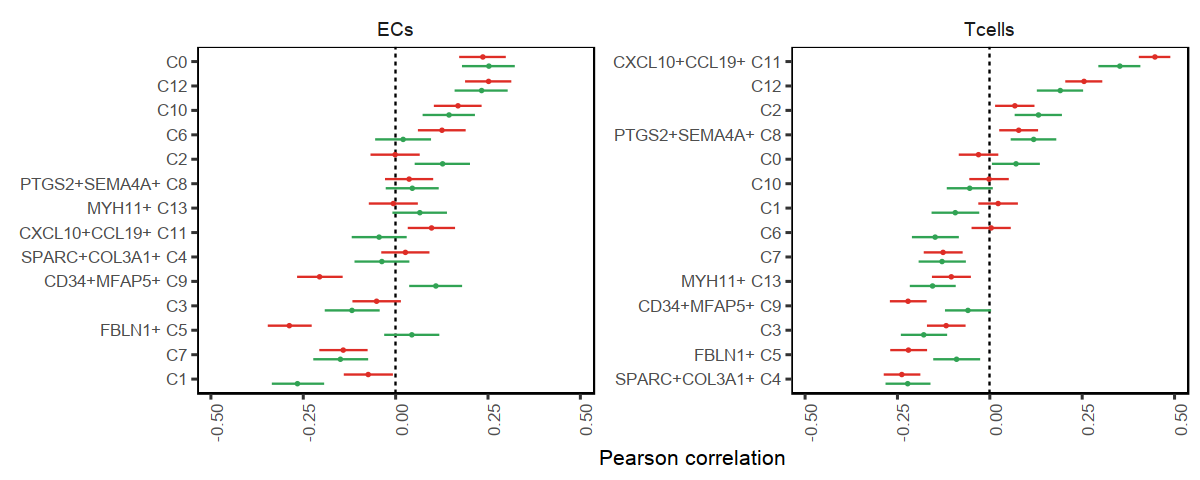

In [57]:
fig.size(4, 10)
p_culture_cor <- cor_df %>% 
    ggplot(aes(reorder_within(Cluster_name, estimate, Condition), estimate, color = Tissue)) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_point(position = position_dodge(width = 0.75), size = .5) + 
        geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0, position = position_dodge(width = 0.75)) + 
        facet_wrap(~Condition, scales = 'free_y') + 
        coord_flip() + 
        scale_color_manual(values = palette_global[c('Lung', 'Synovium')]) + 
        scale_y_continuous(limits = c(-max(abs(cor_df$conf.high)), max(abs(cor_df$conf.high)))) + 
        labs(y = 'Pearson correlation', x = 'Fibroblast Cluster') + 
        scale_x_reordered() + 
        guides(color = 'none') + 
        theme(
            legend.position='bottom',
            axis.title.y = element_blank(),
            axis.text.x = element_text(angle = 90, hjust = 1)
        ) + 
        NULL

p_culture_cor

# What did get turned on with +ECs? 

In [26]:
library(fgsea)
go <- list(
    BP = readRDS('/data/srlab2/ik936/Roche/data/pathways/GO_Biological_Process_2018.rds'),
    CC = readRDS('/data/srlab2/ik936/Roche/data/pathways/GO_Cellular_Component_2018.rds'),
    MF = readRDS('/data/srlab2/ik936/Roche/data/pathways/GO_Molecular_Function_2018.rds')
)
# go <- readRDS('/data/srlab2/ik936/Roche/data/pathways/KEGG_2019_Human.rds')
# go <- readRDS('/data/srlab2/ik936/Roche/data/pathways/GO_Molecular_Function_2018.rds')


In [27]:
# x <- data.table(ddres_costim)[Condition == 'Tcells', .(log2FoldChange = mean(log2FoldChange)), by = feature]
x <- data.table(ddres_costim)[Condition == 'ECs', .(log2FoldChange = mean(log2FoldChange)), by = feature]
# x <- data.table(ddres_costim)[Condition == 'ECs', .(log2FoldChange = mean(log2FoldChange)), by = feature]
# x <- subset(ddres_costim, Condition == 'ECs' & Tissue == 'lung')
# x <- subset(ddres_costim, Condition == 'ECs' & Tissue == 'fls')
r <- x$log2FoldChange
names(r) <- x$feature
# .x <- fgsea(go, r)
.x <- map(go, fgsea, r)
.x <- bind_rows(.x, .id = 'Ontology')


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (15.14% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (15.14% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (15.14% of the list).
The order of those tied genes will be 

In [28]:
# .x %>% 
#     subset(padj < .01 & NES > 0) %>% 
#     arrange(-NES) %>% 
#     dplyr::select(-leadingEdge) %>% 
#     head(10)


In [29]:
# .x %>% 
#     subset(padj < .01 & NES > 0) %>% 
#     arrange(-NES) %>% 
#     dplyr::select(-leadingEdge) %>% 
#     split(.$Ontology) %>% map(head, 10)


In [30]:
fwrite(.x, '/data/srlab2/ik936/Roche/manuscript/tables/EC_coculture_GO_pathways.csv', sep = ',')

# 3D 

In [31]:
dds_fls3d <- readRDS('/data/srlab2/ik936/Roche/data/cache/micromass_deseq2.rds')

head(dds_fls3d)

,feature,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,COL3A1,25220.652,5.002895,0.05748340,87.03200,0,0
2,IGFBP7,4256.958,4.018324,0.05423130,74.09603,0,0
3,COL4A1,3302.325,3.784767,0.05672943,66.71612,0,0
4,BGN,6105.515,3.368662,0.05096730,66.09457,0,0
5,SPARC,11361.454,2.473261,0.03925548,63.00421,0,0
6,OLFM2,2036.874,4.414150,0.07172393,61.54362,0,0


## correlation

In [32]:
plt_df <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% subset(Tissue %in% c('Synovium')) %>% 
    inner_join(
        dds_fls3d,
        by = c('feature'), suffix = c('_cluster', '_culture')
    ) %>% 
    subset(
        (pvalue_cluster < .01 & abs(beta) > 1) | 
        (pvalue_culture < .01 & abs(log2FoldChange) > 1)
    ) %>% 
    subset(!is.na(log2FoldChange)) %>% 
    identity()
head(plt_df)

contrast,Cluster,Tissue,feature,beta,sigma,zscore,pvalue_cluster,baseMean,log2FoldChange,lfcSE,stat,pvalue_culture,padj
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9|Synovium,9,Synovium,PI16,5.731668,0.6866517,8.347271,3.492922e-17,0.3937417,0.29355578,0.32071328,0.9153216,3.600228e-01,NA
11|Synovium,11,Synovium,CCL19,5.085097,0.7209392,7.053433,8.727806e-13,6.8379947,2.86046385,0.52316993,5.4675617,4.562684e-08,4.206159e-07
9|Synovium,9,Synovium,FBLN2,2.388281,0.3418056,6.987250,1.401636e-12,429.1835270,0.67383645,0.09835433,6.8511108,7.327872e-12,9.430475e-11
9|Synovium,9,Synovium,NHSL1,3.022156,0.4707499,6.419876,6.819259e-11,74.4170216,0.08008249,0.21149722,0.3786456,7.049511e-01,8.327231e-01
11|Synovium,11,Synovium,IL32,1.937907,0.3024368,6.407642,7.389370e-11,226.6861790,0.79346575,0.13531705,5.8637529,4.525208e-09,4.646322e-08
9|Synovium,9,Synovium,MFAP5,3.943333,0.6163440,6.397942,7.874277e-11,3290.7515968,1.06835160,0.13388946,7.9793552,1.470997e-15,2.482557e-14


In [33]:
cor_df <- plt_df %>% 
    split(paste(.$Cluster)) %>% 
    map(function(.SD) {
        broom::tidy(cor.test(~beta + log2FoldChange, .SD))
    }) %>% 
    bind_rows(.id = 'Cluster') %>% 
    left_join(cluster_names_df)
head(cor_df)

Joining, by = "Cluster"



Cluster,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative,Cluster_name
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0,0.050908310,1.7421021,8.175380e-02,1168,-0.006421228,0.10790429,Pearson's product-moment correlation,two.sided,C0
1,0.123209406,4.2358644,2.456379e-05,1164,0.066269090,0.17934986,Pearson's product-moment correlation,two.sided,C1
10,0.042349394,1.4560557,1.456432e-01,1180,-0.014705151,0.09912906,Pearson's product-moment correlation,two.sided,C10
11,0.084012127,2.9796227,2.941817e-03,1249,0.028722165,0.13878959,Pearson's product-moment correlation,two.sided,CXCL10+CCL19+ C11
12,-0.014063174,-0.4798470,6.314263e-01,1164,-0.071414577,0.04338091,Pearson's product-moment correlation,two.sided,C12
13,-0.009140055,-0.3146488,7.530837e-01,1185,-0.066004503,0.04778357,Pearson's product-moment correlation,two.sided,MYH11+ C13


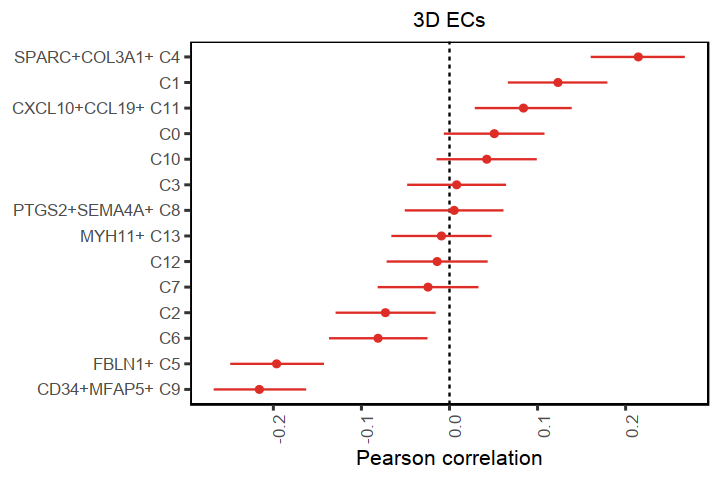

In [34]:
fig.size(4, 6)
p_3d_cor <- cor_df %>% 
    cbind(Tissue = 'Synovium') %>% 
    ggplot(aes(reorder(Cluster_name, estimate), estimate, color = Tissue)) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_point(position = position_dodge(width = 0.75)) + 
        geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0, position = position_dodge(width = 0.75)) + 
        coord_flip() + 
#         labs(y = 'Pearson correlation', x = 'Fibroblast Cluster') + 
        labs(y = 'Pearson correlation', x = 'Fibroblast Cluster', title = '3D ECs') + 
        scale_x_reordered() + 
        theme(
            plot.title = element_text(size = 12, hjust = .5),
            axis.title.y = element_blank(),
            axis.text.x = element_text(angle = 90, hjust = 1)
        ) + 
        scale_color_manual(values = palette_global['Synovium']) +
        guides(color = 'none') + 
        NULL

p_3d_cor

## Focused corplot

In [61]:
plt_df <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% subset(Tissue %in% c('Synovium')) %>% 
    inner_join(
        dds_fls3d,
        by = c('feature'), suffix = c('_cluster', '_culture')
    ) %>% 
    subset(!is.na(log2FoldChange)) %>% 
    identity()
head(plt_df)

contrast,Cluster,Tissue,feature,beta,sigma,zscore,pvalue_cluster,baseMean,log2FoldChange,lfcSE,stat,pvalue_culture,padj
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9|Synovium,9,Synovium,PI16,5.731668,0.6866517,8.347271,3.492922e-17,0.3937417,0.29355578,0.32071328,0.9153216,3.600228e-01,NA
11|Synovium,11,Synovium,CCL19,5.085097,0.7209392,7.053433,8.727806e-13,6.8379947,2.86046385,0.52316993,5.4675617,4.562684e-08,4.206159e-07
9|Synovium,9,Synovium,FBLN2,2.388281,0.3418056,6.987250,1.401636e-12,429.1835270,0.67383645,0.09835433,6.8511108,7.327872e-12,9.430475e-11
9|Synovium,9,Synovium,NHSL1,3.022156,0.4707499,6.419876,6.819259e-11,74.4170216,0.08008249,0.21149722,0.3786456,7.049511e-01,8.327231e-01
11|Synovium,11,Synovium,IL32,1.937907,0.3024368,6.407642,7.389370e-11,226.6861790,0.79346575,0.13531705,5.8637529,4.525208e-09,4.646322e-08
9|Synovium,9,Synovium,MFAP5,3.943333,0.6163440,6.397942,7.874277e-11,3290.7515968,1.06835160,0.13388946,7.9793552,1.470997e-15,2.482557e-14


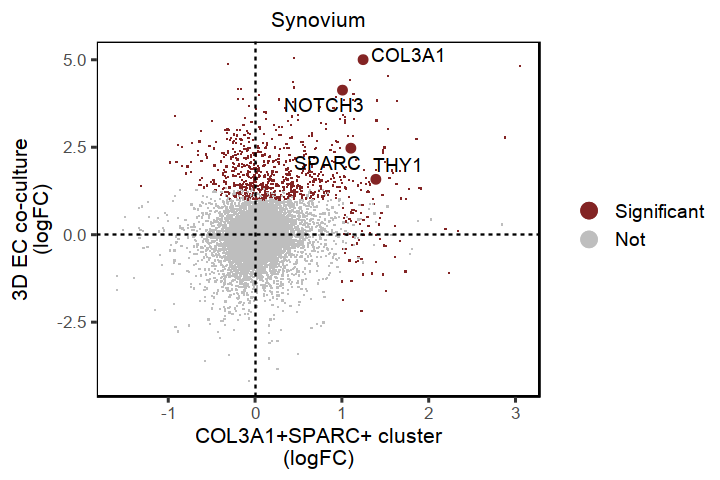

In [62]:
fig.size(4, 6)
p_culture3d_cor_focus <- plt_df %>% 
    dplyr::mutate(Label = case_when(
        (pvalue_cluster < .01 & (beta) > 1) | (pvalue_culture < .01 & (log2FoldChange) > 1) ~ 'Significant', 
        TRUE ~ 'Not'
    )) %>% 
    dplyr::mutate(Label = factor(Label, c('Significant', 'Not'))) %>% 
    subset(Cluster == '4') %>% 
    ggplot(aes(beta, log2FoldChange)) + 
        geom_point(shape = '.', aes(color = Label)) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_text_repel(
            data = . %>% subset(feature %in% c('THY1', 'COL3A1', 'SPARC', 'NOTCH3')), 
            aes(label = feature)
        ) + 
        geom_point(
            data = . %>% subset(feature %in% c('THY1', 'COL3A1', 'SPARC', 'NOTCH3')), 
            aes(color = Label), size = 2
        ) + 
        scale_color_manual(values = c(muted('red'), 'grey')) + 
        guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4)), alpha = 'none') + 
        labs(x = 'COL3A1+SPARC+ cluster\n(logFC)', y = '3D EC co-culture\n(logFC)', title = 'Synovium') + 
        theme(
            legend.title = element_blank(),
#             legend.position='bottom',
            plot.title = element_text(size = 12, hjust = .5)
        ) + 
        NULL

p_culture3d_cor_focus

# Panels

In [42]:
library(png)
fname <- '/data/srlab2/ik936/Roche/manuscript/figures/coculture_design.png'
img <- readPNG(fname)
g <- rasterGrob(img, interpolate=TRUE)#, width=1, height=.7)


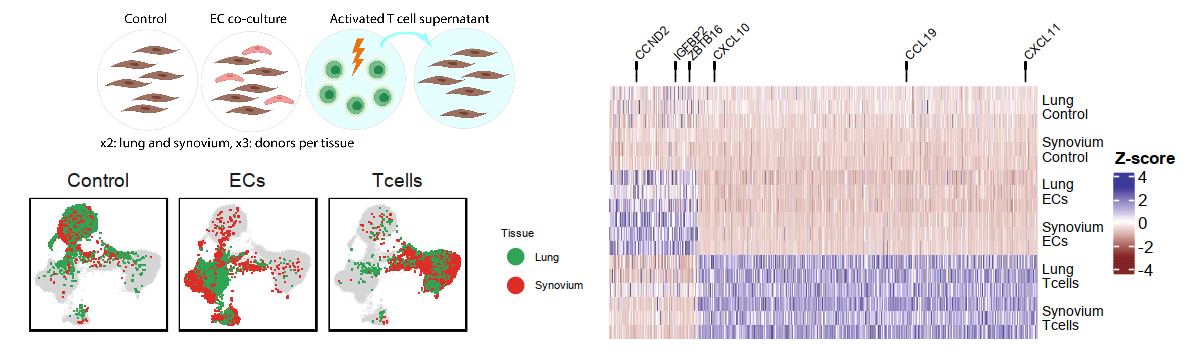

In [43]:
row1 <- (
    (
        (wrap_elements(full = g) / wrap_elements(full = p_umap)) + plot_layout(heights = c(1, 1.5))
    ) | 
    wrap_elements(full = p_stim_heat)
) + 
# ((wrap_elements(full = g) / p_umap) | wrap_elements(full = p_stim_heat)) + 
    plot_layout(widths = c(1, 1)) 
#     plot_annotation(tag_levels = 'a')

fig.size(3, 10)
row1

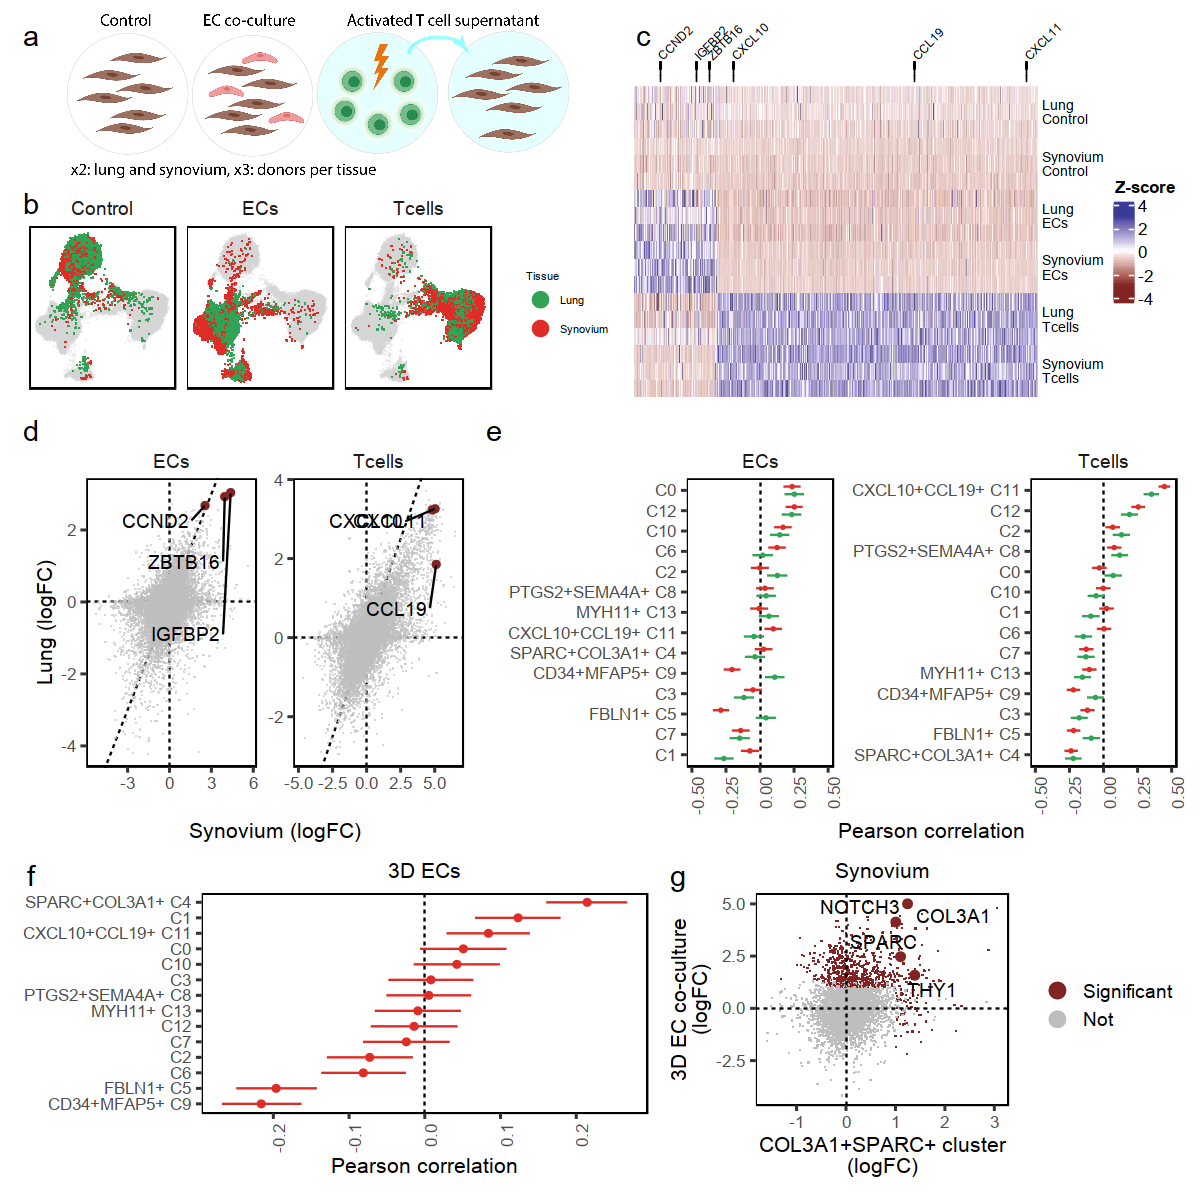

In [64]:
fig.size(10, 10)
set.seed(47L)
p_final <- ( ## Full figure
#     (
#         ## Row 1
        
# #         (wrap_elements(full = g) | wrap_elements(full=p_umap_fls) | wrap_elements(full=p_umap_lung)) + plot_layout(widths = c(.75, 1, 1))
#         (wrap_elements(full = g) | p_umap)
# #         (wrap_elements(full = g) | p_umap_fls | p_umap_lung) + plot_layout(widths = c(.75, 1, 1))
# #         (wrap_elements(grid::textGrob('Study Design Cartoon')) | p_umap_fls | p_umap_lung)# + plot_layout(widths = c(2, 1.5, 1.5))
#     ) / ( 
    row1 / (
        ## Row 2
        (p_scatter_tissue | p_culture_cor) + plot_layout(widths = c(1, 1.3))
#         (wrap_elements(full = p_stim_heat) | p_scatter_tissue) + plot_layout(widths = c(1, 1))
    ) / (
        ## Row 3
#         (wrap_elements(full = p_culture_cor) | p_culture_cor_focus)
#         (wrap_elements(full=p_culture_cor) | wrap_elements(full=p_culture_cor_focus))
        (wrap_elements(full = p_3d_cor) | wrap_elements(full = p_culture3d_cor_focus)) + 
#         (wrap_elements(full=p_culture_cor_focus) | wrap_elements(full = p_3d_cor) | p_culture3d_cor_focus) + 
        plot_layout(widths = c(.8, .7))
        
    )
) +  
    plot_layout(heights = c(1.2, 1, 1)) + 
    plot_annotation(tag_levels = 'a')

p_final

In [65]:
ggsave(
    filename = '/data/srlab2/ik936/Roche/manuscript/figures/Figure5.pdf', 
    plot = p_final, 
    units = 'in', device = 'pdf', 
    height = 10, width = 10,
    useDingbats = FALSE
)


ggsave(
    filename = '/data/srlab2/ik936/Roche/manuscript/figures/Figure5.png', 
    plot = p_final, 
    units = 'in', device = 'png', 
    height = 10, width = 10
)
